# Benchmark Decision Tree with Simple Dataset Split

# 1. Libraries

In [1]:
%matplotlib inline

#data organizing
import pandas #storage
import numpy as np #data-type conversion
from os import getcwd

#preprocessing
from sklearn.model_selection import train_test_split #to split the data

#classifier
from sklearn.tree import DecisionTreeClassifier

#classification result - statistical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#graphical
import seaborn #barplots
from matplotlib.pyplot import subplots #to resize plots

#classification result - graphical
from sklearn.tree import export_graphviz

# 2. Dataset - Importing

In [2]:
#dtype changed from int64 to int32 to save space and speed up computation, no data was lost
def cvDefPay(prediction):
    mapper = {0: False, 1: True}
    return mapper.get(prediction)

url = getcwd() + '\\default of credit card clients.xls'
ccd = pandas.read_excel(io = url, \
                        sheet_name='Data', header = 1, index_col = 0, \
                        dtype = {'LIMIT_BAL': np.int32, 'AGE': np.int32, 'BILL_AMT1': np.int32, 'BILL_AMT2': np.int32, 'BILL_AMT3': np.int32, 'BILL_AMT4': np.int32, 'BILL_AMT5': np.int32, 'BILL_AMT6': np.int32, 'PAY_AMT1': np.int32, 'PAY_AMT2': np.int32, 'PAY_AMT3': np.int32, 'PAY_AMT4': np.int32, 'PAY_AMT5': np.int32, 'PAY_AMT6': np.int32}, \
                        converters = {'default payment next month': cvDefPay})

In [3]:
ccd.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)
ccd.rename(columns = {'default payment next month': 'default_payment_next_month'}, inplace = True)

# 3. Splitting the dataset

In [4]:
ccdY = pandas.DataFrame(ccd['default_payment_next_month'])
ccdX = ccd.drop(['default_payment_next_month'], axis = 'columns')

In [5]:
trainX, testX, trainY, testY = train_test_split(ccdX, ccdY, test_size = 0.25, random_state = 44)

# 4. Classification

## Without PAY_MODE_SEVEREST, BILL_AMT_MEAN and PAY_AMT_MEAN

### criterion

which goodness-of-fit criteion to use?

gini index or information gain(entropy)? Entropy is better metric for categorical targets and getting rulesets

https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb

http://www.learnbymarketing.com/481/decision-tree-flavors-gini-info-gain/

https://link.springer.com/article/10.1023%2FB%3AAMAI.0000018580.96245.c6

https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf

https://datascience.stackexchange.com/questions/23253/decision-trees-c4-5-vs-cart-rule-sets

### max_depth

Which max_depth to use?

Since not specifying a max_depth leads to overfitting(100% accuracy on test) and excessively large tree(~65000 leaves)

1. semi-arbitrary number, linked to count of features.

    a. ratio - arbitrary depth (for a beginning), to ensure the tree size is sane and not extremely overfitting.

    treeDepthToFeatureCountRatio = 0.125

    b. log() - since the count of leaves (using features for splitting) and tree_depth are directly correlated(2 * depth + 1), log shoul;d prove inverse to this correlation

In [6]:
classifier = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = len(ccdX.columns) * 0.25, random_state = 39)

In [7]:
classifier = classifier.fit(trainX, trainY)

## 4.a. Classifier results - Statistical

In [8]:
classifier.score(trainX, trainY)

0.8229333333333333

In [9]:
classifier.score(testX, testY)

0.8218666666666666

In [10]:
predictY = classifier.predict(testX)
print(classification_report(testY, predictY))

              precision    recall  f1-score   support

       False       0.84      0.95      0.89      5851
        True       0.68      0.36      0.47      1649

    accuracy                           0.82      7500
   macro avg       0.76      0.66      0.68      7500
weighted avg       0.81      0.82      0.80      7500



In [11]:
#http://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/
pandas.DataFrame(
    confusion_matrix(testY, predictY),
    columns=['Predicted | Not Defaulter', 'Defaulter'],
    index=['Correct | Not Defaulter', 'Defaulter'])

,Predicted | Not Defaulter,Defaulter
Correct | Not Defaulter,5570,281
Defaulter,1055,594


## 4.b. Classifier results - Graphical

https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

NOTE: Use http://webgraphviz.com/ to view and export graphviz dot files

In [12]:
export_graphviz(classifier, out_file='02BenchmarkDecisionTree.dot', feature_names = ccdX.columns,
                class_names = ['True', 'False'], label = 'all', impurity = True,
                rounded = True, proportion = False, filled = True)#, precision = 2)

## 4.c. Relative importance of Features
https://datawhatnow.com/feature-importance/

In [13]:
featureImportance = pandas.DataFrame()
featureImportance['FeatureName'] = trainX.columns
featureImportance['Importance'] = classifier.feature_importances_

fi = featureImportance[featureImportance['Importance'] > 0.01]

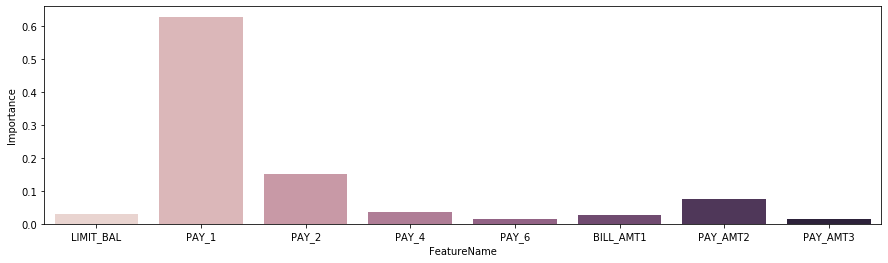

In [14]:
fig_dims = (15, 4)
fig, ax = subplots(figsize=fig_dims)

seaborn.barplot(x = 'FeatureName', y = 'Importance', data = fi, ax = ax, palette = seaborn.cubehelix_palette(8))

## With PAY_MODE_SEVEREST, BILL_AMT_MEAN and PAY_AMT_MEAN

## 3.a. Feature engineering

In [15]:
ccdr = pandas.read_excel(io = url, 
                        sheet_name='Data', header = 1, index_col = 0)
ccdr.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)

ccdrPayHistory = ccdr[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

ccdrPayHistoryMode = ccdrPayHistory.mode(axis = 'columns')
ccdrPayHistorySeverest = ccdrPayHistoryMode.apply(func = max, axis = 'columns')

ccd['PAY_MODE_SEVEREST'] = ccdrPayHistorySeverest

In [16]:
ccdSpent = ccd[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
ccd['BILL_AMT_MEAN'] = np.int32(ccdSpent.mean(axis = 'columns').round())

In [17]:
ccdSettled = ccd[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
ccd['PAY_AMT_MEAN'] = np.int32(ccdSettled.mean(axis = 'columns').round())

## 3.b. Splitting the dataset

In [18]:
ccdY = pandas.DataFrame(ccd['default_payment_next_month'])
ccdX = ccd.drop(['default_payment_next_month'], axis = 'columns')

In [19]:
trainX, testX, trainY, testY = train_test_split(ccdX, ccdY, test_size = 0.25, random_state = 44)

# 4. Classification

In [20]:
classifier = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = len(ccdX.columns) * 0.25, random_state = 39)

In [21]:
classifier = classifier.fit(trainX, trainY)

## 4.a. Classification Result - Statistical

In [22]:
classifier.score(trainX, trainY)

0.8263555555555555

In [23]:
predictY = classifier.predict(testX)
print(classification_report(testY, predictY))

              precision    recall  f1-score   support

       False       0.84      0.95      0.89      5851
        True       0.69      0.36      0.48      1649

    accuracy                           0.82      7500
   macro avg       0.77      0.66      0.68      7500
weighted avg       0.81      0.82      0.80      7500



In [24]:
#http://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/
pandas.DataFrame(
    confusion_matrix(testY, predictY),
    columns=['Predicted | Not Defaulter', 'Defaulter'],
    index=['Correct | Not Defaulter', 'Defaulter'])

,Predicted | Not Defaulter,Defaulter
Correct | Not Defaulter,5581,270
Defaulter,1051,598


## 4.b. Relative importance of Features
https://datawhatnow.com/feature-importance/

In [25]:
featureImportance = pandas.DataFrame()
featureImportance['FeatureName'] = trainX.columns
featureImportance['Importance'] = classifier.feature_importances_

fi = featureImportance[featureImportance['Importance'] > 0.01]

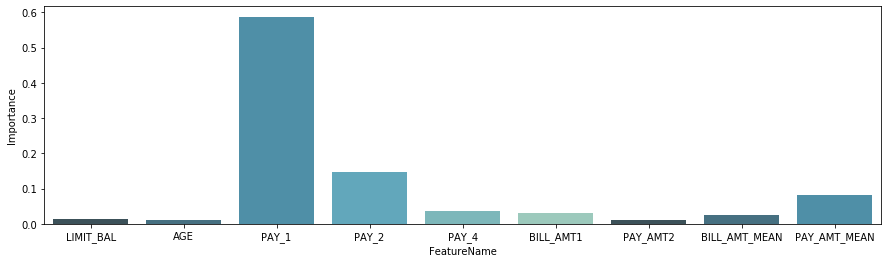

In [26]:
fig_dims = (15, 4)
fig, ax = subplots(figsize=fig_dims)

seaborn.barplot(x = 'FeatureName', y = 'Importance', data = fi, ax = ax, palette = seaborn.color_palette("GnBu_d"))

# Conclusion:
Decision Tree with summarized variables' dataset has slightly better:
1. Not defaulter prediction (+11 out of correct 5851, total 7500)
2. Defaulter prediction (+4 out of total 1649, total 7500)